In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2

Using TensorFlow backend.


In [2]:
cancer_labs = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)

def append_ext(fn):
    return fn+".tif"

cancer_labs["id"]=cancer_labs["id"].apply(append_ext)

print("Cancer image data set count:", cancer_labs.shape[0])

Cancer image data set count: 220025


In [3]:
class_count = cancer_labs["label"].value_counts()

print("Positive cancer scans:", class_count[1])
print("Positive cancer scans percent:", round(class_count[1] / cancer_labs.shape[0], 2) * 100)
print("Negative cancer scans:", class_count[0])
print("Negative cancer scans percent:", round(class_count[0] / cancer_labs.shape[0], 2) * 100)

Positive cancer scans: 89117
Positive cancer scans percent: 41.0
Negative cancer scans: 130908
Negative cancer scans percent: 59.0


In [4]:
train, test = train_test_split(cancer_labs, test_size=0.2, random_state=1017)

print("Cancer image training set rows:", train.shape[0])
print("Cancer image test set rows:", test.shape[0])

Cancer image training set rows: 176020
Cancer image test set rows: 44005


In [5]:
batch_size = 128

image_size = (96, 96)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train, 
    directory='../input/histopathologic-cancer-detection/train/', 
    x_col='id', 
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    has_ext=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test, 
    directory='../input/histopathologic-cancer-detection/train/', 
    x_col='id', 
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    has_ext=False
)

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


In [6]:
weights_path = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model  = VGG19(include_top=False, weights= weights_path,input_shape=(96, 96, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_initializer='glorot_uniform', use_bias=False)(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)
x = Dense(128, activation='relu', use_bias=False)(x)
x = Dropout(.5)(x)
predictions = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = base_model.input, outputs = predictions)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["binary_accuracy"])

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history  = model.fit_generator(generator=train_generator, 
                                         epochs=20, 
                                         steps_per_epoch=512, 
                                         validation_data=test_generator, 
                                         validation_steps=128,
                                        callbacks = [earlyStopping,mcp_save])

Epoch 1/20
512/512 [==============================] - 396s 773ms/step - loss: 0.4875 - binary_accuracy: 0.7819 - val_loss: 6.5008 - val_binary_accuracy: 0.5967
Epoch 2/20
512/512 [==============================] - 385s 751ms/step - loss: 0.4190 - binary_accuracy: 0.8207 - val_loss: 9.4259 - val_binary_accuracy: 0.4088
Epoch 3/20
512/512 [==============================] - 369s 721ms/step - loss: 0.3927 - binary_accuracy: 0.8313 - val_loss: 1.5026 - val_binary_accuracy: 0.4969
Epoch 4/20
512/512 [==============================] - 337s 659ms/step - loss: 0.3971 - binary_accuracy: 0.8320 - val_loss: 8.4259 - val_binary_accuracy: 0.4009
Epoch 5/20
512/512 [==============================] - 339s 661ms/step - loss: 0.3485 - binary_accuracy: 0.8526 - val_loss: 2.2176 - val_binary_accuracy: 0.6018
Epoch 6/20
512/512 [==============================] - 337s 658ms/step - loss: 0.3175 - binary_accuracy: 0.8705 - val_loss: 0.4103 - val_binary_accuracy: 0.8109
Epoch 7/20
512/512 [====================

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

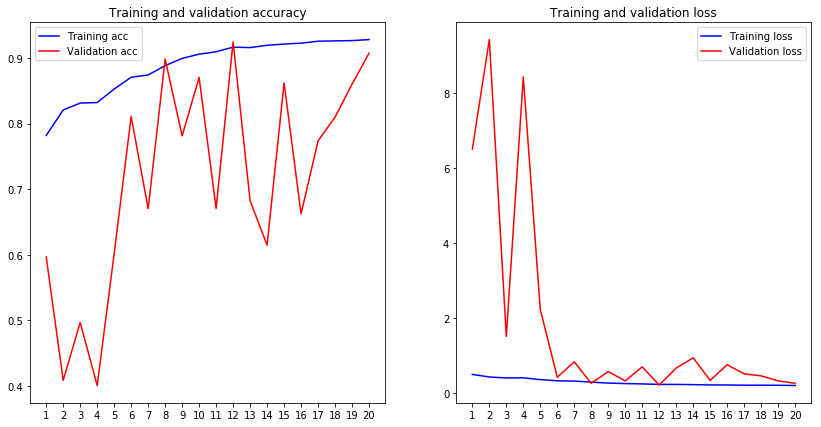

In [9]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history["binary_accuracy"]
    val_acc = history.history["val_binary_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="Training acc")
    plt.plot(x, val_acc, "r", label="Validation acc")
    plt.xticks(x, x)
    plt.title("Training and validation accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="Training loss")
    plt.plot(x, val_loss, "r", label="Validation loss")
    plt.xticks(x, x)
    plt.title("Training and validation loss")
    plt.legend()
    
plot_history(history=history)

In [13]:
model_two_eval = model.evaluate_generator(generator = test_generator, 
                                              steps = np.ceil(len(test_generator.filenames) / batch_size))

print("Loss Value:", model_two_eval[0].round(4))
print("Model Test Accuracy:", model_two_eval[1].round(4))

Loss Value: 0.2581
Model Test Accuracy: 0.9056


In [14]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=test, 
    directory='../input/histopathologic-cancer-detection/train/', 
    x_col='id', 
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    has_ext=False,
    shuffle=False
)

model_two_probs = model.predict_generator(generator = val_generator, 
                                              steps = np.ceil(len(val_generator.filenames) / batch_size))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_generator.classes, model_two_probs)

print("Model AUC:", auc(fpr_keras, tpr_keras).round(4))

Found 44005 images belonging to 2 classes.
Model AUC: 0.966
